# Preprocessing CGE data

In [47]:
# the following code lines are necessary to import custom module
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import boto3
import io
import json
import pandas as pd
import numpy as np
from src.preprocessing.data_preparation_and_cleaning import change_features_names, get_station_name
from src.preprocessing.feature_engineer import get_wind_components, resample_data
from statsmodels.tsa.seasonal import STL

In [48]:
# # AWS credentials to read files on S3 bucket
# f = open('../credentials.json')
# credentials = json.load(f)

# s3_client = boto3.client(
#     's3',
#     aws_access_key_id=credentials["Access key ID"],
#     aws_secret_access_key=credentials["Secret access key"]
#     )

# s3_resource = boto3.resource(
#     's3',
#     aws_access_key_id=credentials["Access key ID"],
#     aws_secret_access_key=credentials["Secret access key"]
#     )

In [49]:
# df_full = []
# for year in list(range(2009, 2019+1)):  
#     prefix=f"raw/{year}/"
#     prefix_objs = s3_resource.Bucket("cge").objects.filter(Prefix=prefix)
#     keys = [obj.key for obj in prefix_objs]
#     for key in keys:
#         obj = s3_client.get_object(Bucket="cge", Key=key)
#         df = pd.read_csv(io.BytesIO(obj["Body"].read()))
#         df_full.append(df)

In [50]:
# cge = pd.concat(df_full, ignore_index=True)
# cge = cge.drop_duplicates(ignore_index=True)
# cge = get_station_name(cge)
# cge[['Posto Nome']] = cge[['Posto Nome']].replace('NaN', '1000300')

# cge = cge[[
#     'Posto',
#     'Posto Nome',
#     'DATA',
#     'PLU(mm)',
#     'Vel.VT(m/s)',
#     'Dir.VT(o)',
#     'Temp(oC)',
#     'Umid.Rel.(%)',
#     'Pressão(mb)',
#     'Rajada.VT(m/s)',
#     'Sens. Térmica(°C)'
#     ]]

# cge = cge[cge['Posto Nome'].isin(['Sé', 'Lapa', 'Pirituba', 'Penha', 'Jabaquara', 'Parelheiros'])]
# cge = change_features_names(cge)

In [51]:
# lapa = cge[cge.station_name == "Lapa"] \
#     .dropna(subset=["precipitation", "wind_velocity", "wind_direction", "temperature", "relative_humidity", "pressure", "wind_blow"]) \
#     .reset_index(drop=True) \
#     .drop(["thermal_sensation"], axis=1)

# lapa.to_csv("../data/raw/lapa.csv")

In [52]:
# rural = cge[cge.station_name == "Parelheiros"] \
#     .dropna(subset=["precipitation", "wind_velocity", "wind_direction", "temperature", "relative_humidity", "pressure", "wind_blow"]) \
#     .reset_index(drop=True) \
#     .drop(["thermal_sensation"], axis=1)

# rural = rural.set_index("timestamp")
# rural = rural.drop(["station", "station_name"], axis=1)
# rural.columns = [f"{i}_rural" for i in list(rural.columns)]
# rural = rural.reset_index()

# rural.to_csv("../data/raw/rural.csv")

In [53]:
lapa = pd.read_csv("../data/raw/lapa.csv").drop("Unnamed: 0", axis=1)
rural = pd.read_csv("../data/raw/rural.csv").drop("Unnamed: 0", axis=1)

In [54]:
lapa = lapa.merge(rural, on="timestamp")
lapa["uhi"] = lapa.temperature - lapa.temperature_rural 
lapa

,station,station_name,timestamp,precipitation,wind_velocity,wind_direction,temperature,relative_humidity,pressure,wind_blow,precipitation_rural,wind_velocity_rural,wind_direction_rural,temperature_rural,relative_humidity_rural,pressure_rural,wind_blow_rural,uhi
0,1000848,Lapa,2016-01-21 14:10:00,0.0,5.640,166.041,24.054,62.180,934.53,6.580,0.25,2.444,203.645,23.349,64.585,926.27,6.768,0.705
1,1000848,Lapa,2016-01-21 14:20:00,0.6,2.068,129.338,24.034,62.821,934.42,6.580,0.25,2.632,207.687,23.067,63.846,926.30,6.768,0.967
2,1000848,Lapa,2016-01-21 14:30:00,0.6,1.880,100.178,23.983,59.360,934.36,5.264,0.25,4.512,228.272,22.724,65.348,926.29,6.768,1.259
3,1000848,Lapa,2016-01-21 14:40:00,0.6,2.444,168.234,23.822,60.172,934.72,7.332,0.25,4.136,230.220,22.483,65.647,926.38,6.956,1.339
4,1000848,Lapa,2016-01-21 14:50:00,0.6,2.256,161.165,23.903,59.659,935.08,7.520,0.25,2.820,227.683,22.805,64.908,926.08,5.640,1.098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154890,1000848,Lapa,2019-02-18 22:00:00,0.0,0.000,182.327,24.890,80.888,931.12,3.384,0.00,0.940,219.600,20.942,95.568,923.08,1.128,3.948
154891,1000848,Lapa,2019-02-18 22:10:00,0.0,0.000,159.136,24.527,82.646,931.63,2.068,0.00,0.188,187.969,20.871,95.776,923.25,1.504,3.656
154892,1000848,Lapa,2019-02-18 22:20:00,0.0,0.000,157.964,24.376,83.934,931.18,0.000,0.00,0.000,188.378,20.660,95.971,922.98,0.752,3.716
154893,1000848,Lapa,2019-02-18 22:30:00,0.0,0.000,135.862,24.225,84.697,931.76,2.820,0.00,0.940,187.805,20.609,96.075,922.77,0.940,3.616


In [55]:
# lapa = get_wind_components(
#     lapa, 
#     wind_velocity='wind_velocity', 
#     wind_direction='wind_direction', 
#     x_name='wind_velocity_x', 
#     y_name='wind_velocity_y'
#     )

# lapa = get_wind_components(
#     lapa, 
#     wind_velocity='wind_velocity_rural', 
#     wind_direction='wind_direction_rural', 
#     x_name='wind_velocity_x_rural', 
#     y_name='wind_velocity_y_rural'
#     )

# lapa = lapa.drop(['wind_velocity', "wind_velocity_rural"], axis=1)

# lapa = get_wind_components(
#     lapa, 
#     wind_velocity='wind_blow', 
#     wind_direction='wind_direction', 
#     x_name='wind_blow_x', 
#     y_name='wind_blow_y'
#     )

# lapa = get_wind_components(
#     lapa, 
#     wind_velocity='wind_blow_rural', 
#     wind_direction='wind_direction_rural', 
#     x_name='wind_blow_x_rural', 
#     y_name='wind_blow_y_rural'
#     )

lapa = lapa.drop(['wind_blow', 'wind_blow_rural'], axis=1)
lapa = lapa.drop(['wind_direction', "wind_direction_rural"], axis=1)
lapa = resample_data(lapa)
lapa = lapa.reset_index()
lapa = lapa.set_index("timestamp")

lapa

/home/ubuntu/ml-uhi/src/preprocessing/feature_engineer.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample(rule='60min').mean()


,station,precipitation,wind_velocity,temperature,relative_humidity,pressure,precipitation_rural,wind_velocity_rural,temperature_rural,relative_humidity_rural,pressure_rural,uhi,station_name
timestamp,,,,,,,,,,,,,
2016-01-21 14:00:00,1000848,0.48,2.857600,23.959200,60.838400,934.622000,0.25,3.308800,22.885600,64.866800,926.264000,1.073600,Lapa
2016-01-21 15:00:00,1000848,0.60,3.540667,24.260500,59.027167,934.495000,0.25,2.538000,23.360333,65.310167,925.856667,0.900167,Lapa
2016-01-21 16:00:00,1000848,0.60,3.666000,24.631000,56.776833,934.336667,0.25,4.167333,22.873667,63.563500,925.821667,1.757333,Lapa
2016-01-21 17:00:00,1000848,0.60,2.820000,24.642833,55.731833,934.245000,0.25,2.506667,22.880500,64.743333,925.243333,1.762333,Lapa
2016-01-21 18:00:00,1000848,0.60,3.854000,24.625833,55.659833,933.590000,0.25,3.070667,22.210500,66.918667,925.206667,2.415333,Lapa
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-18 18:00:00,1000848,0.00,2.099333,27.068333,67.378167,930.448333,0.00,2.224667,24.683000,77.648167,922.628333,2.385333,Lapa
2019-02-18 19:00:00,1000848,0.00,1.378667,26.657000,69.979500,930.051667,0.00,2.130667,23.723167,84.699167,921.975000,2.933833,Lapa
2019-02-18 20:00:00,1000848,0.00,0.219333,26.392000,71.525833,930.355000,0.00,1.472667,22.447333,89.048167,922.263333,3.944667,Lapa


In [56]:
to_drop = [
    'precipitation',
    'temperature',
    'relative_humidity',
    'pressure',
    'precipitation_rural',
    'temperature_rural',
    'relative_humidity_rural',
    'pressure_rural',
    # 'uhi',
    # 'wind_velocity_x',
    # 'wind_velocity_y',
    # 'wind_velocity_x_rural',
    # 'wind_velocity_y_rural',
    # 'wind_blow_x',
    # 'wind_blow_y',
    # 'wind_blow_x_rural',
    # 'wind_blow_y_rural',
    'station',
    'station_name',
    'wind_velocity',
    'wind_velocity_rural'
]

cols = list(lapa.drop(to_drop, axis=1).columns)
cols

['uhi']

In [57]:
# def get_outliers(df, features, factor):
#     for feature in features:
#         df_ = df.copy()
#         df_rolling_stats = df_[feature].rolling(window=24, center=True, min_periods=1).agg({"rolling_mean": "mean", "rolling_std": "std"})
#         df_[["rolling_mean", "rolling_std"]] = df_rolling_stats
#         df[f"{feature}_outlier"] = np.abs(df_[feature] - df_["rolling_mean"]) > factor * df_["rolling_std"]
#         df[f"{feature}_outlier"] = df[f"{feature}_outlier"].astype(int)
#     return df


def get_outliers(df, features, factor):
    df_outliers = pd.DataFrame()
    for feature in features:
        df_ = df.copy()
        df_rolling_stats = df_[feature].rolling(window=24, center=True, min_periods=1).agg({"rolling_mean": "mean", "rolling_std": "std"})
        df_[["rolling_mean", "rolling_std"]] = df_rolling_stats
        df_outliers[f"{feature}_outlier"] = np.abs(df_[feature] - df_["rolling_mean"]) > factor * df_["rolling_std"]
        df_outliers[f"{feature}_outlier"] = df_outliers[f"{feature}_outlier"].astype(int)
    return df_outliers

In [58]:
df_outliers = get_outliers(df=lapa, features=cols, factor=3)
df_outliers

,uhi_outlier
timestamp,
2016-01-21 14:00:00,0
2016-01-21 15:00:00,0
2016-01-21 16:00:00,0
2016-01-21 17:00:00,0
2016-01-21 18:00:00,0
...,...
2019-02-18 18:00:00,0
2019-02-18 19:00:00,0
2019-02-18 20:00:00,0


In [59]:
outliers = lapa[["uhi"]].merge(df_outliers[["uhi_outlier"]], left_index=True, right_index=True)
outliers = outliers[outliers.uhi_outlier == 1].drop("uhi_outlier", axis=1)
outliers

,uhi
timestamp,
2016-02-11 16:00:00,6.826833
2016-02-15 16:00:00,7.875833
2016-02-28 21:00:00,4.782333
2016-03-12 18:00:00,6.633667
2016-03-25 18:00:00,4.681500
...,...
2018-09-15 19:00:00,7.351833
2018-09-29 18:00:00,7.692667
2018-09-30 18:00:00,7.003167


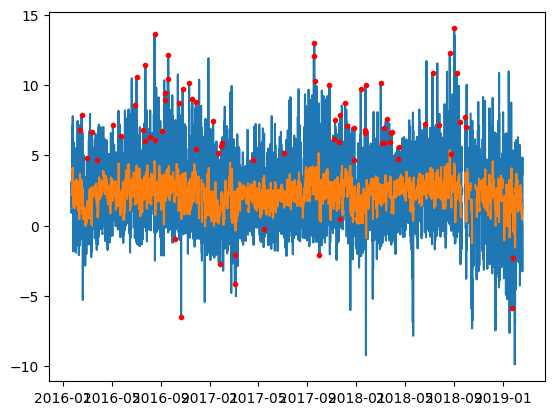

In [60]:
import matplotlib.pyplot as plt
plt.plot(lapa.uhi)
plt.plot(lapa.uhi.rolling(24).mean())
plt.plot(outliers.uhi, ls="", marker=".", color="red")
plt.show()

In [61]:
cols = list(lapa.drop([
    "station", 
    "station_name",
    'precipitation',
    'wind_velocity',
    'temperature',
    'relative_humidity',
    'pressure',
    'precipitation_rural',
    'wind_velocity_rural',
    'temperature_rural',
    'relative_humidity_rural',
    'pressure_rural',
], axis=1).columns)

cols

['uhi']

In [62]:
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.timeseries.forecasting import LagFeatures, WindowFeatures
from sklearn.pipeline import Pipeline

In [63]:
lapa = lapa[["uhi"]]

In [64]:
# binary features
dtf = DatetimeFeatures(
    variables="index",
    features_to_extract=[
        "month",
        "hour",
    ],
)

lagf = LagFeatures(
    variables="uhi_outlier", # the input variables
    freq=[f"{i}H" for i in range(1,3)], # move 1 hr to n hrs forward
    missing_values="ignore"
)

winf = WindowFeatures(
    variables=["uhi_outlier"], # the input variables
    window=["3H", "6H", "12H"], 
    freq="1H", # move 1 hr forward
    functions=["sum"],
    missing_values="ignore"
)

pipe_binary_features = Pipeline(
    [
        ("dtf", dtf),
        ("lagf", lagf),
        ("winf", winf)
    ]
)

df_binary_features = pipe_binary_features.fit_transform(df_outliers)

In [65]:
# continuous features
dtf = DatetimeFeatures(
    variables="index",
    features_to_extract=[
        "month",
        "hour",
    ],
)

lagf = LagFeatures(
    variables="uhi", # the input variables
    freq=[f"{i}H" for i in range(1,3)], # move 1 hr to n hrs forward
    missing_values="ignore"
)

winf = WindowFeatures(
    variables=["uhi"], # the input variables
    window=["3H", "6H", "12H"],
    freq="1H", # move 1 hr forward
    functions=["mean", "std", "min", "max"],
    missing_values="ignore"
)

cyclicf = CyclicalFeatures(
    variables=["month", "hour"], # The features we want to transform.
    drop_original=False, # Whether to drop the original features.
)

pipe_continuous_features = Pipeline(
    [
        ("dtf", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("cyclicf", cyclicf),
    ]
)

df_continuous_features = pipe_continuous_features.fit_transform(lapa)
df_continuous_features = df_continuous_features.drop(["month", "hour"], axis=1)

In [66]:
# import datetime

# def get_season(x):
#     try:
#         if x >= datetime.datetime(x.year, 12, 21) and x < datetime.datetime(x.year, 1, 1):
#             return "summer"
#         elif x >= datetime.datetime(x.year, 1, 1) and x < datetime.datetime(x.year, 3, 21):
#             return "summer"
#         elif x >= datetime.datetime(x.year, 3, 21) and x < datetime.datetime(x.year, 6, 21):
#             return "autumn"
#         elif x >= datetime.datetime(x.year, 6, 21) and x < datetime.datetime(x.year, 9, 23):
#             return "winter"
#         elif x >= datetime.datetime(x.year, 9, 23) and x < datetime.datetime(x.year, 12, 21):
#             return "spring"
#     except:
#         pass

# lapa["season"] = lapa.reset_index("timestamp")["timestamp"].apply(get_season)
# lapa["season"]

In [67]:
import datetime

# def get_season2(x):
#     try:
#         if x == 12:
#             return "summer"
#         elif x >= 1 and x <= 3:
#             return "summer"
#         elif x > 3 and x <= 6:
#             return "autumn"
#         elif x > 6 and x <= 9:
#             return "winter"
#         elif x > 9 and x < 12:
#             return "spring"
#     except:
#         pass

def get_season2(x):
    try:
        if x == 9 or x == 10 or x == 11 or x == 12 or x == 1 or x == 2:
            return "spring_summer"
        else:
            return "autumn_winter"
    except:
        pass

df_binary_features["season"] = df_binary_features["month"].apply(get_season2)
df_binary_features["season"].unique()

array(['spring_summer', 'autumn_winter'], dtype=object)

In [68]:
dummies = pd.get_dummies(df_binary_features[["season"]])
df_binary_features = df_binary_features.reset_index().merge(dummies, on="timestamp").set_index("timestamp")

In [69]:
# lapa.to_csv("../data/processed/lapa.csv", index=True)
lapa.to_csv("../data/processed/lapa2.csv", index=True)

df_continuous_features.to_csv("../data/processed/df_continuous_features.csv", index=True)
df_binary_features.to_csv("../data/processed/df_binary_features.csv", index=True)